In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

Execute

```
git clone https://github.com/alexeygrigorev/clothing-dataset-small.git
```

to get the data

## Loading Images

In [3]:
from tensorflow.keras.preprocessing.image import load_img 

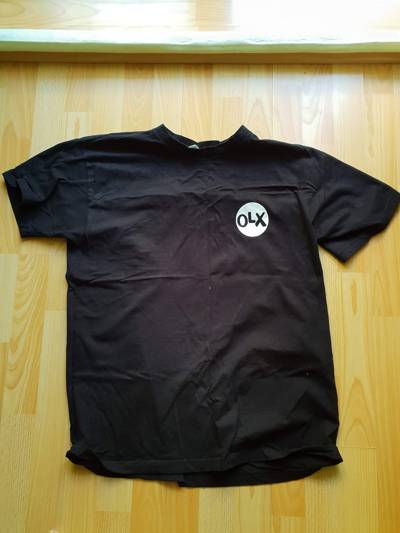

In [4]:
path = './clothing-dataset-small/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = path + '/' + name
load_img(fullname)

Usually we resize images. This is how a network will see these images:

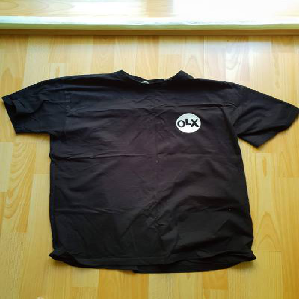

In [5]:
load_img(fullname, target_size=(299, 299))

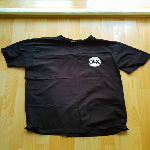

In [6]:
load_img(fullname, target_size=(150, 150))

## Pre-Trained Neural Network

Let's apply a pre-trained neural network with imagenet classes.

We'll use Xception, but any other architecture will work as well.

Check here for a list of available models:

* https://keras.io/api/applications/
* https://www.tensorflow.org/api_docs/python/tf/keras/applications


We'll need to import 3 things:

* the model itself (`Xception`)
* the `preprocess_input` function that takes an image and prepares it
* the `decode_predictions` that converts the predictions of the model into human-readable classes

In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

Let's load the model. The pre-trained model expects 299x299 input

In [8]:
model = Xception(
    weights='imagenet',
    input_shape=(299, 299, 3)
)

Next,

* we load the image using the `load_img` function
* convert it to a numpy array
* make it a batch of one example

In [9]:
img = load_img(fullname, target_size=(299, 299))
x = np.array(img)
x.shape

(299, 299, 3)

In [10]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

We're ready!

Next, we will:

* prepare the input
* do the predictions
* convert the predictions into a human-readable format

In [11]:
X = preprocess_input(X)

In [12]:
pred = model.predict(X)

In [13]:
pred.shape

(1, 1000)

In [14]:
pred[0, :10]

array([0.0003238 , 0.00015736, 0.00021406, 0.00015296, 0.00024657,
       0.00030446, 0.00032349, 0.00014726, 0.00020487, 0.00014866],
      dtype=float32)

In [15]:
decode_predictions(pred)

[[('n03595614', 'jersey', 0.67924464),
  ('n02916936', 'bulletproof_vest', 0.039600343),
  ('n04370456', 'sweatshirt', 0.035299607),
  ('n03710637', 'maillot', 0.010884146),
  ('n04525038', 'velvet', 0.0018057624)]]

Not quite what we wanted... Let's train our own model

## Transfer learning

Instead of loading each image one-by-one, we can use a data generator. Keras will use it for loading the images and pre-processing them

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We'll use smaller images - it'll be faster

In [17]:
image_size = (150, 150)
batch_size = 32

Let's get train data:

In [18]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


And validation:

In [19]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


For fine-tuning, we'll use `Xception` with small images (150x150)

In [20]:
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

base_model.trainable = False

Let's add a small neural net on top of that: just one layer with 10 neurons (there are 10 classes we want to predict)

In [21]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vector)

model = keras.Model(inputs, outputs)

Now we specify the learning rate and compile the model. After that, it's ready for training

In [22]:
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

Let's train now for 10 epochs:

In [23]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Train for 96 steps, validate for 11 steps
Epoch 1/10
96/96 [==============================] - 22s 227ms/step - loss: 1.2372 - accuracy: 0.6734 - val_loss: 0.8453 - val_accuracy: 0.7713
Epoch 2/10
96/96 [==============================] - 16s 163ms/step - loss: 0.6023 - accuracy: 0.8194 - val_loss: 0.7928 - val_accuracy: 0.7859
Epoch 3/10
96/96 [==============================] - 16s 164ms/step - loss: 0.3485 - accuracy: 0.8801 - val_loss: 0.7924 - val_accuracy: 0.7859
Epoch 4/10
96/96 [==============================] - 16s 164ms/step - loss: 0.2219 - accuracy: 0.9234 - val_loss: 0.8765 - val_accuracy: 0.7918
Epoch 5/10
96/96 [==============================] - 16s 165ms/step - loss: 0.2111 - accuracy: 0.9260 - val_loss: 0.9354 - val_accuracy: 0.8065
Epoch 6/10
96/96 [==============================] - 16s 165ms/step - loss: 0.1716 - accuracy: 0.9426 - val_loss: 0.9824 - val_accuracy: 0.7889
Epoch 7/10
96/96 [==============================] - 16s 165ms/step - loss: 0.1068 - accuracy: 0.9615

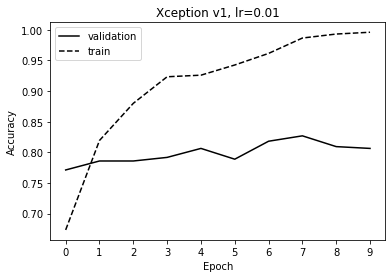

In [24]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('xception_v1_0_01.svg')

plt.show()

0.01 is not necessarily the best learning rate, so we should experiment with 0.001 and 0.0001.

To make it easier for us, let's make a function for defining our model:

In [25]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

Watching metrics this way is not convenient, so let's create a special callback for that

In [26]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Train for 96 steps, validate for 11 steps
Epoch 1/10
96/96 [==============================] - 19s 196ms/step - loss: 1.1015 - accuracy: 0.6291 - val_loss: 0.7096 - val_accuracy: 0.7830
Epoch 2/10
96/96 [==============================] - 16s 163ms/step - loss: 0.6252 - accuracy: 0.7832 - val_loss: 0.6204 - val_accuracy: 0.8123
Epoch 3/10
96/96 [==============================] - 16s 164ms/step - loss: 0.5067 - accuracy: 0.8370 - val_loss: 0.6059 - val_accuracy: 0.8065
Epoch 4/10
96/96 [==============================] - 16s 165ms/step - loss: 0.4265 - accuracy: 0.8611 - val_loss: 0.5871 - val_accuracy: 0.8123
Epoch 5/10
96/96 [==============================] - 16s 165ms/step - loss: 0.3729 - accuracy: 0.8846 - val_loss: 0.5525 - val_accuracy: 0.8270
Epoch 6/10
96/96 [==============================] - 16s 165ms/step - loss: 0.3229 - accuracy: 0.9045 - val_loss: 0.5472 - val_accuracy: 0.8152
Epoch 7/10
96/96 [==============================] - 16s 165ms/step - loss: 0.2879 - accuracy: 0.9228

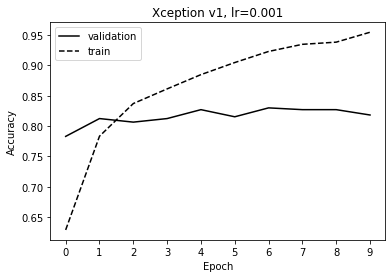

In [27]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_001.svg')

plt.show()

In [28]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=10, validation_data=val_ds)

Train for 96 steps, validate for 11 steps
Epoch 1/10
96/96 [==============================] - 19s 196ms/step - loss: 1.9388 - accuracy: 0.3409 - val_loss: 1.5844 - val_accuracy: 0.5044
Epoch 2/10
96/96 [==============================] - 16s 164ms/step - loss: 1.3929 - accuracy: 0.5479 - val_loss: 1.2417 - val_accuracy: 0.6217
Epoch 3/10
96/96 [==============================] - 16s 165ms/step - loss: 1.1497 - accuracy: 0.6317 - val_loss: 1.0638 - val_accuracy: 0.6716
Epoch 4/10
96/96 [==============================] - 16s 165ms/step - loss: 1.0089 - accuracy: 0.6770 - val_loss: 0.9546 - val_accuracy: 0.7097
Epoch 5/10
96/96 [==============================] - 16s 165ms/step - loss: 0.9145 - accuracy: 0.7050 - val_loss: 0.8825 - val_accuracy: 0.7302
Epoch 6/10
96/96 [==============================] - 16s 165ms/step - loss: 0.8458 - accuracy: 0.7314 - val_loss: 0.8348 - val_accuracy: 0.7361
Epoch 7/10
96/96 [==============================] - 16s 166ms/step - loss: 0.7917 - accuracy: 0.7484

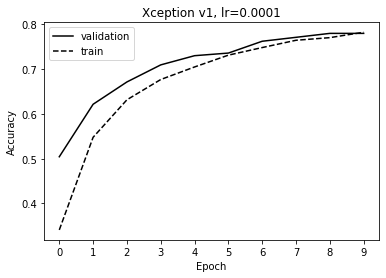

In [29]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_0001.svg')

plt.show()

In [30]:
epochs = np.arange(10)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

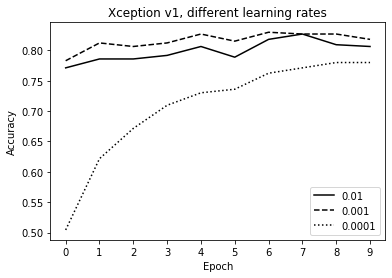

In [31]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('Xception v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('xception_v1_all_lr.svg')

plt.show()

The best models:

* learning rate 0.01: 0.8270
* learning rate 0.001: 0.8299
* learning rate 0.0001: 0.7801

(your results may be slightly different)

To save the best model, we can use a callback. It'll monitor the accuracy, and if it's an improvement over the previous version, it'll save the model to disk

In [32]:
model = make_model(learning_rate=0.001)

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Train for 96 steps, validate for 11 steps
Epoch 1/10
96/96 [==============================] - 19s 199ms/step - loss: 1.0845 - accuracy: 0.6340 - val_loss: 0.7188 - val_accuracy: 0.7654
Epoch 2/10
96/96 [==============================] - 16s 168ms/step - loss: 0.6271 - accuracy: 0.7816 - val_loss: 0.6328 - val_accuracy: 0.7889
Epoch 3/10
96/96 [==============================] - 16s 167ms/step - loss: 0.4964 - accuracy: 0.8413 - val_loss: 0.5812 - val_accuracy: 0.8094
Epoch 4/10
96/96 [==============================] - 16s 164ms/step - loss: 0.4198 - accuracy: 0.8621 - val_loss: 0.5962 - val_accuracy: 0.7889
Epoch 5/10
96/96 [==============================] - 16s 164ms/step - loss: 0.3713 - accuracy: 0.8840 - val_loss: 0.5565 - val_accuracy: 0.8065
Epoch 6/10
96/96 [==============================] - 16s 168ms/step - loss: 0.3251 - accuracy: 0.9061 - val_loss: 0.5585 - val_accuracy: 0.8299
Epoch 7/10
96/96 [==============================] - 16s 165ms/step - loss: 0.2868 - accuracy: 0.9228

Let's add one more layer - and a dropout between them

In [34]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [35]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Train for 96 steps, validate for 11 steps
Epoch 1/30
96/96 [==============================] - 19s 199ms/step - loss: 0.9504 - accuracy: 0.6744 - val_loss: 0.6143 - val_accuracy: 0.8006
Epoch 2/30
96/96 [==============================] - 16s 166ms/step - loss: 0.4989 - accuracy: 0.8217 - val_loss: 0.5565 - val_accuracy: 0.8152
Epoch 3/30
96/96 [==============================] - 16s 164ms/step - loss: 0.3445 - accuracy: 0.8859 - val_loss: 0.6129 - val_accuracy: 0.7889
Epoch 4/30
96/96 [==============================] - 16s 166ms/step - loss: 0.2387 - accuracy: 0.9270 - val_loss: 0.5456 - val_accuracy: 0.8123
Epoch 5/30
96/96 [==============================] - 16s 166ms/step - loss: 0.1673 - accuracy: 0.9527 - val_loss: 0.5837 - val_accuracy: 0.8065
Epoch 6/30
96/96 [==============================] - 16s 166ms/step - loss: 0.1140 - accuracy: 0.9746 - val_loss: 0.5879 - val_accuracy: 0.8152
Epoch 7/30
96/96 [==============================] - 16s 170ms/step - loss: 0.0751 - accuracy: 0.9896

In [36]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Train for 96 steps, validate for 11 steps
Epoch 1/30
96/96 [==============================] - 19s 201ms/step - loss: 1.0704 - accuracy: 0.6408 - val_loss: 0.7279 - val_accuracy: 0.7830
Epoch 2/30
96/96 [==============================] - 16s 164ms/step - loss: 0.6188 - accuracy: 0.7846 - val_loss: 0.6079 - val_accuracy: 0.7830
Epoch 3/30
96/96 [==============================] - 16s 168ms/step - loss: 0.4696 - accuracy: 0.8357 - val_loss: 0.5803 - val_accuracy: 0.8182
Epoch 4/30
96/96 [==============================] - 16s 169ms/step - loss: 0.3710 - accuracy: 0.8732 - val_loss: 0.5724 - val_accuracy: 0.8416
Epoch 5/30
96/96 [==============================] - 16s 165ms/step - loss: 0.2964 - accuracy: 0.9009 - val_loss: 0.5414 - val_accuracy: 0.8065
Epoch 6/30
96/96 [==============================] - 16s 166ms/step - loss: 0.2257 - accuracy: 0.9283 - val_loss: 0.5795 - val_accuracy: 0.8182
Epoch 7/30
96/96 [==============================] - 16s 165ms/step - loss: 0.1901 - accuracy: 0.9413

In [37]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Train for 96 steps, validate for 11 steps
Epoch 1/30
96/96 [==============================] - 20s 207ms/step - loss: 1.2893 - accuracy: 0.5717 - val_loss: 0.7348 - val_accuracy: 0.7859
Epoch 2/30
96/96 [==============================] - 16s 169ms/step - loss: 0.8462 - accuracy: 0.7099 - val_loss: 0.6297 - val_accuracy: 0.8094
Epoch 3/30
96/96 [==============================] - 16s 166ms/step - loss: 0.6839 - accuracy: 0.7585 - val_loss: 0.5952 - val_accuracy: 0.8094
Epoch 4/30
96/96 [==============================] - 16s 169ms/step - loss: 0.6017 - accuracy: 0.7898 - val_loss: 0.5717 - val_accuracy: 0.8152
Epoch 5/30
96/96 [==============================] - 16s 166ms/step - loss: 0.5271 - accuracy: 0.8123 - val_loss: 0.5566 - val_accuracy: 0.8065
Epoch 6/30
96/96 [==============================] - 16s 169ms/step - loss: 0.4703 - accuracy: 0.8338 - val_loss: 0.5297 - val_accuracy: 0.8270
Epoch 7/30
96/96 [==============================] - 16s 166ms/step - loss: 0.3811 - accuracy: 0.8732

In [38]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

Train for 96 steps, validate for 11 steps
Epoch 1/30
96/96 [==============================] - 20s 206ms/step - loss: 1.7922 - accuracy: 0.3999 - val_loss: 1.1657 - val_accuracy: 0.6510
Epoch 2/30
96/96 [==============================] - 16s 171ms/step - loss: 1.4048 - accuracy: 0.5130 - val_loss: 0.9569 - val_accuracy: 0.7302
Epoch 3/30
96/96 [==============================] - 16s 171ms/step - loss: 1.2486 - accuracy: 0.5629 - val_loss: 0.8736 - val_accuracy: 0.7566
Epoch 4/30
96/96 [==============================] - 16s 168ms/step - loss: 1.1612 - accuracy: 0.5870 - val_loss: 0.7757 - val_accuracy: 0.7537
Epoch 5/30
96/96 [==============================] - 16s 171ms/step - loss: 1.0790 - accuracy: 0.6053 - val_loss: 0.7731 - val_accuracy: 0.7742
Epoch 6/30
96/96 [==============================] - 16s 168ms/step - loss: 1.0593 - accuracy: 0.6268 - val_loss: 0.7370 - val_accuracy: 0.7683
Epoch 7/30
96/96 [==============================] - 16s 171ms/step - loss: 0.9958 - accuracy: 0.6333

In [39]:
epochs = history_0.epoch

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

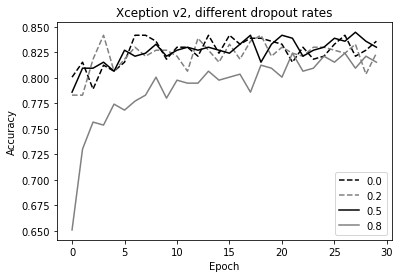

In [40]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

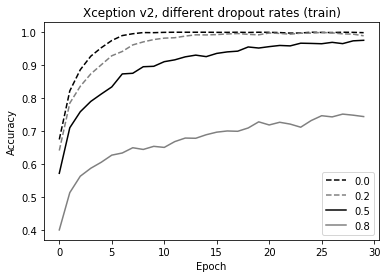

In [41]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

## Data augmentation

In [42]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [43]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [44]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

Train for 96 steps, validate for 11 steps
Epoch 1/50
96/96 [==============================] - 31s 319ms/step - loss: 1.1175 - accuracy: 0.6258 - val_loss: 0.6942 - val_accuracy: 0.7801
Epoch 2/50
96/96 [==============================] - 27s 282ms/step - loss: 0.7214 - accuracy: 0.7523 - val_loss: 0.6231 - val_accuracy: 0.7801
Epoch 3/50
96/96 [==============================] - 27s 280ms/step - loss: 0.5948 - accuracy: 0.8005 - val_loss: 0.5920 - val_accuracy: 0.7771
Epoch 4/50
96/96 [==============================] - 28s 292ms/step - loss: 0.5141 - accuracy: 0.8201 - val_loss: 0.5654 - val_accuracy: 0.8270
Epoch 5/50
96/96 [==============================] - 27s 280ms/step - loss: 0.4627 - accuracy: 0.8413 - val_loss: 0.5753 - val_accuracy: 0.8152
Epoch 6/50
96/96 [==============================] - 27s 280ms/step - loss: 0.4150 - accuracy: 0.8566 - val_loss: 0.6029 - val_accuracy: 0.8123
Epoch 7/50
96/96 [==============================] - 27s 282ms/step - loss: 0.3859 - accuracy: 0.8634

In [45]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

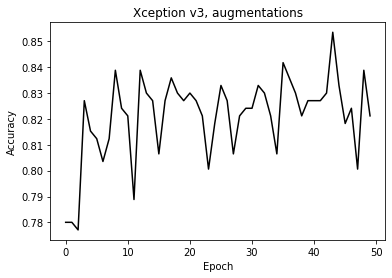

In [46]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('Xception v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('xception_v3_aug.svg')

plt.show()

## Larger model

In [47]:
def make_model(learning_rate, droprate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [48]:
image_size = (299, 299)
batch_size = 32

In [49]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "clothing-dataset-small/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 3068 images belonging to 10 classes.


In [50]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "clothing-dataset-small/validation",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 341 images belonging to 10 classes.


In [51]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v4_large_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_l = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

Train for 96 steps, validate for 11 steps
Epoch 1/20
96/96 [==============================] - 78s 815ms/step - loss: 0.8443 - accuracy: 0.7272 - val_loss: 0.4424 - val_accuracy: 0.8592
Epoch 2/20
96/96 [==============================] - 75s 785ms/step - loss: 0.4331 - accuracy: 0.8455 - val_loss: 0.3982 - val_accuracy: 0.8710
Epoch 3/20
96/96 [==============================] - 75s 785ms/step - loss: 0.3875 - accuracy: 0.8651 - val_loss: 0.3825 - val_accuracy: 0.8739
Epoch 4/20
96/96 [==============================] - 76s 788ms/step - loss: 0.3356 - accuracy: 0.8774 - val_loss: 0.3828 - val_accuracy: 0.8680
Epoch 5/20
96/96 [==============================] - 75s 785ms/step - loss: 0.2973 - accuracy: 0.8980 - val_loss: 0.3681 - val_accuracy: 0.8886
Epoch 6/20
96/96 [==============================] - 75s 781ms/step - loss: 0.2736 - accuracy: 0.9038 - val_loss: 0.3665 - val_accuracy: 0.8856
Epoch 7/20
63/96 [==================>...........] - ETA: 24s - loss: 0.2177 - accuracy: 0.9245

Let's test these models now! (see another notebook)